In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/Shareddrives/CS544-Group15/project'

/content/drive/Shareddrives/CS544-Group15/project


In [ ]:
# import necessary packages
# %tensorflow_version 2.x
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, mean_squared_error

Instructions for updating:
non-resource variables are not supported in the long term


# Level 0 - Second Model

In [ ]:
# read data - local and colab
# df1 = pd.read_csv("/Users/nathanli/masterProject/env/data/DP-LSTM_DATA/source_price.csv")
url = './data/source_price_sentiment_oecd.csv'
df2= pd.read_csv(url)
df2.tail()

,date,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,CLI,BCI,CCI
116,2018/5/25,0.030290,0.047433,0.011550,-0.025190,2721.330078,0.7426,1.2187,1.5006
117,2018/5/29,-0.052796,0.070442,-0.025721,-0.035568,2689.860107,0.7426,1.2187,1.5006
118,2018/5/30,-0.017367,0.038119,-0.076965,-0.063177,2724.010010,0.7426,1.2187,1.5006
119,2018/5/31,-0.018636,0.057371,-0.064138,-0.025489,2705.270020,0.7426,1.2187,1.5006
120,2018/6/1,0.000000,-0.061150,0.361200,-0.004489,2734.620117,0.7163,1.3308,1.4417


In [ ]:
# set index to date
df2.index = df2.date
df2.drop('date', axis=1, inplace=True)
df2

,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,CLI,BCI,CCI
date,,,,,,,,
2017/12/7,0.296000,-0.136600,0.000000,0.000000,2636.979980,0.4484,1.3452,1.3407
2017/12/8,0.000000,0.000000,-0.242300,0.000000,2651.500000,0.4484,1.3452,1.3407
2017/12/11,0.000000,0.000000,0.000000,0.000000,2659.989990,0.4484,1.3452,1.3407
2017/12/12,0.000000,0.000000,0.000000,0.000000,2664.110107,0.4484,1.3452,1.3407
2017/12/13,0.000000,0.000000,0.000000,0.000000,2662.850098,0.4484,1.3452,1.3407
...,...,...,...,...,...,...,...,...
2018/5/25,0.030290,0.047433,0.011550,-0.025190,2721.330078,0.7426,1.2187,1.5006
2018/5/29,-0.052796,0.070442,-0.025721,-0.035568,2689.860107,0.7426,1.2187,1.5006
2018/5/30,-0.017367,0.038119,-0.076965,-0.063177,2724.010010,0.7426,1.2187,1.5006


In [ ]:
adjust_close=df2['Adj Close'].values
CLI=df2['CLI'].values
BCI=df2['BCI'].values
CCI=df2['CCI'].values
adjust_close

array([2636.97998 , 2651.5     , 2659.98999 , 2664.110107, 2662.850098,
       2652.01001 , 2675.810059, 2690.159912, 2681.469971, 2679.25    ,
       2684.570068, 2683.340088, 2680.5     , 2682.620117, 2687.540039,
       2673.610107, 2695.810059, 2713.060059, 2723.98999 , 2743.149902,
       2747.709961, 2751.290039, 2748.22998 , 2767.560059, 2786.23999 ,
       2776.419922, 2802.560059, 2798.030029, 2810.300049, 2832.969971,
       2839.129883, 2837.540039, 2839.25    , 2872.870117, 2853.530029,
       2822.429932, 2823.810059, 2821.97998 , 2762.129883, 2648.939941,
       2695.139893, 2681.659912, 2581.      , 2619.550049, 2656.      ,
       2662.939941, 2698.629883, 2731.199951, 2732.219971, 2716.26001 ,
       2701.330078, 2703.959961, 2747.300049, 2779.600098, 2744.280029,
       2713.830078, 2677.669922, 2691.25    , 2720.939941, 2728.120117,
       2726.800049, 2738.969971, 2786.570068, 2783.02002 , 2765.310059,
       2749.47998 , 2747.330078, 2752.01001 , 2712.919922, 2716.

In [ ]:
# nomalize adjust close stock price
scaler = MinMaxScaler()
scaled_adjust_close=scaler.fit_transform(adjust_close.reshape(-1,1))

In [ ]:
# check if adjust close is scaled
scaled_adjust_close

array([[0.19179757],
       [0.2415458 ],
       [0.27063404],
       [0.28475031],
       [0.28043329],
       [0.24329318],
       [0.32483647],
       [0.37400167],
       [0.34422836],
       [0.33662233],
       [0.35484985],
       [0.35063572],
       [0.34090506],
       [0.34816897],
       [0.36502551],
       [0.31729904],
       [0.3933601 ],
       [0.45246173],
       [0.48990966],
       [0.555555  ],
       [0.57117859],
       [0.58344458],
       [0.57296027],
       [0.63918863],
       [0.70318946],
       [0.66954412],
       [0.75910498],
       [0.74358427],
       [0.78562359],
       [0.86329486],
       [0.88439983],
       [0.87895274],
       [0.88481138],
       [1.        ],
       [0.93373735],
       [0.82718277],
       [0.83191134],
       [0.82564115],
       [0.62058386],
       [0.23277457],
       [0.39106399],
       [0.34487913],
       [0.        ],
       [0.13207947],
       [0.25696361],
       [0.28074111],
       [0.40302133],
       [0.514

In [ ]:
new_data=df2.drop(['Adj Close'],axis=1)

new_data['scaled_adj_close'] = scaled_adjust_close

new_data.tail()

,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,CLI,BCI,CCI,scaled_adj_close
date,,,,,,,,
2018/5/25,0.030290,0.047433,0.011550,-0.025190,0.7426,1.2187,1.5006,0.480796
2018/5/29,-0.052796,0.070442,-0.025721,-0.035568,0.7426,1.2187,1.5006,0.372974
2018/5/30,-0.017367,0.038119,-0.076965,-0.063177,0.7426,1.2187,1.5006,0.489978
2018/5/31,-0.018636,0.057371,-0.064138,-0.025489,0.7426,1.2187,1.5006,0.425772
2018/6/1,0.000000,-0.061150,0.361200,-0.004489,0.7163,1.3308,1.4417,0.526330


In [ ]:
new_data.dtypes

wsj_mean_compound        float64
cnbc_mean_compound       float64
fortune_mean_compound    float64
reuters_mean_compound    float64
CLI                      float64
BCI                      float64
CCI                      float64
scaled_adj_close         float64
dtype: object

In [ ]:
new_data.shape

(121, 8)

In [ ]:
# split data into train and test
# train 85% and test 15%
train_validation_data, test_data= train_test_split(new_data, train_size=0.85, test_size=0.15,shuffle=False)

In [ ]:
train_validation_data.tail()

,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,CLI,BCI,CCI,scaled_adj_close
date,,,,,,,,
2018/4/30,-0.009474,0.064056,0.021328,0.066076,0.7434,1.1734,1.5880,0.229726
2018/5/1,-0.044864,0.084246,-0.013291,0.068956,0.7426,1.2187,1.5006,0.252852
2018/5/2,0.000608,0.088057,0.043339,0.053706,0.7426,1.2187,1.5006,0.187309
2018/5/3,0.017188,0.066461,0.063148,0.068072,0.7426,1.2187,1.5006,0.166958
2018/5/4,-0.001986,0.073777,-0.021277,0.062085,0.7426,1.2187,1.5006,0.282386


In [ ]:
train_validation_data.shape

(102, 8)

In [ ]:
validation_data =train_validation_data[83:]
train_data=train_validation_data[:83]

print("train data shape: ", train_data.shape)
print("validation data shape: ", validation_data.shape)
print("test data shape: ", test_data.shape)

train data shape:  (83, 8)
validation data shape:  (19, 8)
test data shape:  (19, 8)


In [ ]:
# configs
look_back = 10
forward_days = 1
NUM_NEURONS=50
EPOCHES=100
BATCH_SIZE=32
DROUP_OUT=0.2

In [ ]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    A,B = [],[]
    for i in range(0,len(data) -look_back, jump):
        A.append(data[i:(i+look_back)])
        B.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(A), np.array(B)

In [ ]:
m_training_data = train_data.to_numpy()
m_validation_data = validation_data.to_numpy()
m_test_data = test_data.to_numpy()

X_train,Y_train = processData(m_training_data,look_back,forward_days)
X_validation,Y_validation = processData(m_validation_data,look_back,forward_days)
X_test,Y_test = processData(m_test_data,look_back,forward_days)

In [ ]:
Y_train=Y_train[:,0,-1]
Y_validation=Y_validation[:,0,-1]
Y_test=Y_test[:,0,-1]

print("This is y_train shape",Y_train.shape)
print("This is y_validation shape",Y_validation.shape)
print("This is y_test shape",Y_test.shape)

This is y_train shape (73,)
This is y_validation shape (9,)
This is y_test shape (9,)


# LSTM model

In [ ]:
# build LSTM model
model1 = Sequential()
# first layer
model1.add(LSTM(units=NUM_NEURONS, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Dropout(DROUP_OUT))
# second layer
model1.add(LSTM(units=NUM_NEURONS, return_sequences = True))
model1.add(Dropout(DROUP_OUT))
# third layer
model1.add(LSTM(units=NUM_NEURONS, return_sequences = True))
model1.add(Dropout(DROUP_OUT))
# fourth layer
model1.add(LSTM(units=NUM_NEURONS))
model1.add(Dropout(DROUP_OUT))
# outut layer
model1.add(Dense(forward_days))
#train model
model1.compile(loss='mean_squared_error',optimizer='adam')
              
              # compile
              
history1 =model1.fit(X_train, Y_train, epochs = EPOCHES, batch_size = BATCH_SIZE)

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 1s 19ms/sample - loss: 0.2863
Epoch 2/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.1616
Epoch 3/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0718
Epoch 4/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.1014
Epoch 5/100
73/73 [==============================] - 0s 2ms/sample - loss: 0.0602
Epoch 6/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0637
Epoch 7/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0688
Epoch 8/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0720
Epoch 9/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0721
Epoch 10/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0570
Epoch 11/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0587
Epoch 12/100
73/73 [==============================] - 0s 1ms/sample - loss:

In [ ]:
# build GRU model
model2 = Sequential()
# first layer
model2.add(GRU(units=NUM_NEURONS, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(DROUP_OUT))
# second layer
model2.add(GRU(units=NUM_NEURONS, return_sequences = True))
model2.add(Dropout(DROUP_OUT))
# third layer
model2.add(GRU(units=NUM_NEURONS, return_sequences = True))
model2.add(Dropout(DROUP_OUT))
# fourth layer
model2.add(GRU(units=NUM_NEURONS))
model2.add(Dropout(DROUP_OUT))
# output layer
model2.add(Dense(forward_days))
#train model
model2.compile(loss='mean_squared_error',optimizer='rmsprop')
              
              # compile
              
history2 =model2.fit(X_train, Y_train, epochs = EPOCHES, batch_size = BATCH_SIZE)

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 1s 14ms/sample - loss: 0.1733
Epoch 2/100
73/73 [==============================] - 0s 679us/sample - loss: 0.0918
Epoch 3/100
73/73 [==============================] - 0s 701us/sample - loss: 0.0525
Epoch 4/100
73/73 [==============================] - 0s 720us/sample - loss: 0.0542
Epoch 5/100
73/73 [==============================] - 0s 742us/sample - loss: 0.0647
Epoch 6/100
73/73 [==============================] - 0s 780us/sample - loss: 0.0565
Epoch 7/100
73/73 [==============================] - 0s 811us/sample - loss: 0.0660
Epoch 8/100
73/73 [==============================] - 0s 953us/sample - loss: 0.0693
Epoch 9/100
73/73 [==============================] - 0s 782us/sample - loss: 0.0464
Epoch 10/100
73/73 [==============================] - 0s 763us/sample - loss: 0.0510
Epoch 11/100
73/73 [==============================] - 0s 784us/sample - loss: 0.0432
Epoch 12/100
73/73 [==============================] - 0

# CNN_LSTM

In [ ]:
# build CNN_LSTM model
model4 = Sequential()
# first layer
model4.add(Conv1D(filters=32, kernel_size=1, activation='tanh', padding='same', input_shape=(10, 8)))
# second layer
model4.add(MaxPooling1D(pool_size=1, padding='same'))
# third layer
# NUM_NEURONS = 64
model4.add(LSTM(units=NUM_NEURONS, activation='tanh'))
# fourth layer
model4.add(Dropout(DROUP_OUT))
# output layer
model4.add(Dense(forward_days))
# compile model
model4.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

#train model
history4 = model4.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, shuffle =True)

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 0s 3ms/sample - loss: 0.3382 - mean_squared_error: 0.3382 - mean_absolute_error: 0.5215
Epoch 2/100
73/73 [==============================] - 0s 271us/sample - loss: 0.0910 - mean_squared_error: 0.0910 - mean_absolute_error: 0.2450
Epoch 3/100
73/73 [==============================] - 0s 322us/sample - loss: 0.0674 - mean_squared_error: 0.0674 - mean_absolute_error: 0.2115
Epoch 4/100
73/73 [==============================] - 0s 219us/sample - loss: 0.1164 - mean_squared_error: 0.1164 - mean_absolute_error: 0.2714
Epoch 5/100
73/73 [==============================] - 0s 237us/sample - loss: 0.1275 - mean_squared_error: 0.1275 - mean_absolute_error: 0.2912
Epoch 6/100
73/73 [==============================] - 0s 314us/sample - loss: 0.0631 - mean_squared_error: 0.0631 - mean_absolute_error: 0.2004
Epoch 7/100
73/73 [==============================] - 0s 219us/sample - loss: 0.0572 - mean_squared_error: 0.0572 - mean_abso

In [ ]:
# Xm4=model4.predict(X_validation)
# m4_prediction = scaler.inverse_transform(Xm4)
# print(m4_prediction)

In [ ]:
# from sklearn.metrics import mean_squared_error

# Y_validation = Y_validation.reshape(-1,1)
# m4_Y_validation = scaler.inverse_transform(Y_validation)

# level0_model4_valid_mse = mean_squared_error(m4_prediction, m4_Y_validation)
# print("level 0 model 4 valid MSE ", level0_model4_valid_mse)

In [ ]:
# Xmt4=model4.predict(X_test)
# m4_x_test = scaler.inverse_transform(Xmt4)
# print(m4_x_test)

In [ ]:
# Y_test = Y_test.reshape(-1,1)
# m4_Y_test = scaler.inverse_transform(Y_test)

# level0_model4_test_mse = mean_squared_error(m4_x_test, m4_Y_test)
# print("level 0 model 4 test MSE ", level0_model4_test_mse)

# Attention

In [ ]:
# attention (+LSTM)
%pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

model3 = Sequential()
model3.add(LSTM(units=NUM_NEURONS, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model3.add(Dropout(DROUP_OUT))
model3.add(SeqSelfAttention(attention_activation='sigmoid',attention_width=3, history_only=True, attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL))
model3.add(LSTM(units=NUM_NEURONS))
model3.add(Dropout(DROUP_OUT))
model3.add(Dense(forward_days))
model3.compile(loss='mean_squared_error', optimizer='adam')

history3 =model3.fit(X_train, Y_train, epochs = EPOCHES, batch_size = BATCH_SIZE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Train on 73 samples
Epoch 1/100
73/73 [==============================] - 1s 15ms/sample - loss: 0.5177
Epoch 2/100
73/73 [==============================] - 0s 638us/sample - loss: 0.1303
Epoch 3/100
73/73 [==============================] - 0s 726us/sample - loss: 0.0834
Epoch 4/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.1305
Epoch 5/100
73/73 [==============================] - 0s 806us/sample - loss: 0.0870
Epoch 6/100
73/73 [==============================] - 0s 922us/sample - loss: 0.0643
Epoch 7/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0592
Epoch 8/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0728
Epoch 9/100
73/73 [==============================] - 0s 1ms/sample - loss: 0.0778
Epoch 10/100
73/73 [==============================] - 0s 851us/sample - loss: 0.0620
Epoch 11/100
73/73 [=============================

# Summary

In [ ]:
Xm1=model1.predict(X_validation)
Xm1.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(9, 1)

In [ ]:
Xm2=model2.predict(X_validation)
Xm2.shape

(9, 1)

In [ ]:
Xm3=model3.predict(X_validation)
Xm3.shape

(9, 1)

In [ ]:
Xm4=model4.predict(X_validation)
Xm4.shape

(9, 1)

In [ ]:
print(Xm1)
print(Xm2)
print(Xm3)
print(Xm4)

[[0.3201869 ]
 [0.338841  ]
 [0.34441683]
 [0.3355632 ]
 [0.30157495]
 [0.27438223]
 [0.2636918 ]
 [0.2785882 ]
 [0.30669287]]
[[0.37461334]
 [0.27595052]
 [0.22656173]
 [0.24055731]
 [0.2909872 ]
 [0.3248115 ]
 [0.35585538]
 [0.35705388]
 [0.33494714]]
[[0.36505675]
 [0.34785128]
 [0.29790667]
 [0.24462113]
 [0.21478704]
 [0.21749818]
 [0.25099665]
 [0.2994885 ]
 [0.34222272]]
[[0.33244875]
 [0.23984917]
 [0.21455857]
 [0.22902097]
 [0.2527307 ]
 [0.25013983]
 [0.2784706 ]
 [0.2669969 ]
 [0.25205913]]


In [ ]:
Y_validation = Y_validation.reshape(-1,1)
m_Y_validation = scaler.inverse_transform(Y_validation)
m_Y_validation

array([[2634.560059],
       [2639.399902],
       [2666.939941],
       [2669.909912],
       [2648.050049],
       [2654.800049],
       [2635.669922],
       [2629.72998 ],
       [2663.419922]])

In [ ]:
Y_validation.reshape(-1,1)
Y_validation.shape

(9, 1)

In [ ]:
m1_prediction = scaler.inverse_transform(Xm1)
m2_prediction = scaler.inverse_transform(Xm2)
m3_prediction = scaler.inverse_transform(Xm3)
m4_prediction = scaler.inverse_transform(Xm4)

print(m1_prediction)
print(m2_prediction)
print(m3_prediction)
print(m4_prediction)

[[2674.453 ]
 [2679.8975]
 [2681.525 ]
 [2678.9407]
 [2669.0208]
 [2661.0837]
 [2657.9639]
 [2662.3118]
 [2670.5146]]
[[2690.3384]
 [2661.5417]
 [2647.1267]
 [2651.2114]
 [2665.9304]
 [2675.8027]
 [2684.8635]
 [2685.2134]
 [2678.761 ]]
[[2687.5493]
 [2682.5273]
 [2667.9502]
 [2652.3977]
 [2643.6897]
 [2644.4812]
 [2654.2585]
 [2668.4116]
 [2680.8845]]
[[2678.032 ]
 [2651.005 ]
 [2643.6233]
 [2647.8445]
 [2654.7644]
 [2654.0083]
 [2662.277 ]
 [2658.9282]
 [2654.5686]]


# level 0 model 2 validation unscaled output => m2_prediction

In [ ]:
# getting test data output

In [ ]:
Xmt1=model1.predict(X_test)
Xmt1.shape

(9, 1)

In [ ]:
Xmt2=model2.predict(X_test)
Xmt2.shape

(9, 1)

In [ ]:
Xmt3=model3.predict(X_test)
Xmt3.shape

(9, 1)

In [ ]:
Xmt4=model4.predict(X_test)
Xmt4.shape

(9, 1)

In [ ]:
Y_test.reshape(-1,1)
Y_test.shape

(9,)

In [ ]:
m1_x_test = scaler.inverse_transform(Xmt1)
m2_x_test = scaler.inverse_transform(Xmt2)
m3_x_test = scaler.inverse_transform(Xmt3)
m4_x_test = scaler.inverse_transform(Xmt4)

In [ ]:
m1_x_test

array([[2734.7788],
       [2731.794 ],
       [2722.668 ],
       [2712.209 ],
       [2712.4292],
       [2717.2478],
       [2717.167 ],
       [2719.066 ],
       [2713.425 ]], dtype=float32)

In [ ]:
m2_x_test

array([[2716.1418],
       [2720.0764],
       [2724.202 ],
       [2723.0215],
       [2718.903 ],
       [2715.7388],
       [2710.3655],
       [2712.9397],
       [2711.8274]], dtype=float32)

In [ ]:
m3_x_test

array([[2712.976 ],
       [2704.9458],
       [2700.0134],
       [2696.9324],
       [2699.8992],
       [2703.3171],
       [2701.1592],
       [2698.7236],
       [2690.097 ]], dtype=float32)

In [ ]:
m4_x_test

array([[2712.2866],
       [2719.2246],
       [2720.9802],
       [2720.1958],
       [2718.6624],
       [2717.4211],
       [2707.3235],
       [2713.5327],
       [2708.1416]], dtype=float32)

In [ ]:
Y_test = Y_test.reshape(-1,1)
m_Y_test = scaler.inverse_transform(Y_test)
m_Y_test

array([[2733.01001 ],
       [2724.439941],
       [2733.290039],
       [2727.76001 ],
       [2721.330078],
       [2689.860107],
       [2724.01001 ],
       [2705.27002 ],
       [2734.620117]])

In [ ]:
from sklearn.metrics import mean_squared_error

level0_model1_test_mse = mean_squared_error(m1_x_test, m_Y_test)
print("level 0 model 1 test MSE ", level0_model1_test_mse)

level0_model2_test_mse = mean_squared_error(m2_x_test, m_Y_test)
print("level 0 model 2 test MSE ", level0_model2_test_mse)

level0_model3_test_mse = mean_squared_error(m3_x_test, m_Y_test)
print("level 0 model 3 test MSE ", level0_model3_test_mse)

level0_model4_test_mse = mean_squared_error(m4_x_test, m_Y_test)
print("level 0 model 4 test MSE ", level0_model4_test_mse)

level 0 model 1 test MSE  214.17432570587002
level 0 model 2 test MSE  205.41379135056266
level 0 model 3 test MSE  669.6402252292226
level 0 model 4 test MSE  275.5509708139059


# now train level 1 model with level 0 models' output

In [ ]:
Y_validation

array([[0.18350648],
       [0.20008866],
       [0.29444584],
       [0.3046215 ],
       [0.22972564],
       [0.25285236],
       [0.18730908],
       [0.16695776],
       [0.28238561]])

In [ ]:
m_Y_validation

array([[2634.560059],
       [2639.399902],
       [2666.939941],
       [2669.909912],
       [2648.050049],
       [2654.800049],
       [2635.669922],
       [2629.72998 ],
       [2663.419922]])

In [ ]:
import tensorflow as tf
from tensorflow import keras
model_ensemble = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(9, activation='relu'),
    # keras.layers.Dense(4, activation='relu'),
    # yucen: change from 2 to 3
    # zhiqi: change from 3 to 4
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1)
])

In [ ]:
model_ensemble.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

In [ ]:
scaler = MinMaxScaler()
normalized_x_validation1 = scaler.fit_transform(m1_prediction)
normalized_x_validation2 = scaler.fit_transform(m2_prediction)
normalized_x_validation3 = scaler.fit_transform(m3_prediction)
normalized_x_validation4 = scaler.fit_transform(m4_prediction)

normalized_y_validation = scaler.fit_transform(m_Y_validation)

In [ ]:
level1_train_data = np.concatenate((normalized_x_validation1, 
                                  normalized_x_validation2, 
                                  normalized_x_validation3,
                                  normalized_x_validation4), 
                                 axis=-1)
level1_train_data.shape

(9, 4)

In [ ]:
model_ensemble.fit(level1_train_data, normalized_y_validation, epochs=100, batch_size=2)

Train on 9 samples
Epoch 1/100
9/9 [==============================] - 0s 28ms/sample - loss: 0.2625 - mean_absolute_error: 0.3922
Epoch 2/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.2270 - mean_absolute_error: 0.3868
Epoch 3/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.2104 - mean_absolute_error: 0.3738
Epoch 4/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.1978 - mean_absolute_error: 0.3698
Epoch 5/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.1910 - mean_absolute_error: 0.3643
Epoch 6/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.1862 - mean_absolute_error: 0.3641
Epoch 7/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.1821 - mean_absolute_error: 0.3594
Epoch 8/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.1734 - mean_absolute_error: 0.3603
Epoch 9/100
9/9 [==============================] - 0s 2ms/sample - loss: 0.1710 - mean_absolute_erro

In [ ]:
normalized_x_test1 = scaler.fit_transform(m1_x_test)
normalized_x_test2 = scaler.fit_transform(m2_x_test)
normalized_x_test3 = scaler.fit_transform(m3_x_test)
normalized_x_test4 = scaler.fit_transform(m4_x_test)

In [ ]:
level1_test_data=np.concatenate(
    (normalized_x_test1, 
     normalized_x_test2, 
     normalized_x_test3,
     normalized_x_test4),
     axis=-1)
level1_test_data.shape

(9, 4)

In [ ]:
Xt_ensemble =model_ensemble.predict(level1_test_data)
Xt_ensemble.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(9, 1)

In [ ]:
predicted_stock_price = scaler.inverse_transform(Xt_ensemble)

In [ ]:
mse = mean_squared_error(predicted_stock_price, m_Y_test)
print("Blending Ensemble MSE: ", mse)

Blending Ensemble MSE:  268.58666876927003


In [ ]:
predicted_stock_price

array([[2715.7678],
       [2715.2344],
       [2712.4229],
       [2709.6865],
       [2709.7778],
       [2710.936 ],
       [2712.1396],
       [2712.7227],
       [2712.2805]], dtype=float32)

# Tables & Charts

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def format_score(y_tf, Y_tf, y, Y):
  report = classification_report(y_tf, Y_tf, output_dict=True)
  label = 'weighted avg'
  mpa = round(float(1 - sum(abs(Y-y) / Y) / len(y)), 6)
  mda = accuracy_score(y_tf, Y_tf)
  return [mpa, report[label]['precision'], report[label]['recall'], report[label]['f1-score'], mda]

m_trends = np.zeros((5, len(m1_x_test) - 1))
actual_trends = np.zeros(len(m1_x_test) - 1)
for i in range(1, len(m1_x_test)):
  m_trends[0][i - 1] = m1_x_test[i] > m1_x_test[i - 1]
  m_trends[1][i - 1] = m2_x_test[i] > m2_x_test[i - 1]
  m_trends[2][i - 1] = m3_x_test[i] > m3_x_test[i - 1]
  m_trends[3][i - 1] = m4_x_test[i] > m4_x_test[i - 1]
  m_trends[4][i - 1] = predicted_stock_price[i] > predicted_stock_price[i - 1]
  actual_trends[i - 1] = m_Y_test[i] > m_Y_test[i - 1]

m1_scores = format_score(m_trends[0], actual_trends, m1_x_test, m_Y_test)
m2_scores = format_score(m_trends[1], actual_trends, m2_x_test, m_Y_test)
m3_scores = format_score(m_trends[2], actual_trends, m3_x_test, m_Y_test)
m4_scores = format_score(m_trends[3], actual_trends, m4_x_test, m_Y_test)
m_ensemble_scores = format_score(m_trends[4], actual_trends, predicted_stock_price, m_Y_test)

In [ ]:
# Table
# MSE, MPA, Precision, Recall, F1-score, MDA
data = [
    [level0_model1_test_mse, level0_model2_test_mse, level0_model3_test_mse, level0_model4_test_mse, mse],
    [m1_scores[0], m2_scores[0], m3_scores[0], m4_scores[0], m_ensemble_scores[0]],
    [m1_scores[1], m2_scores[1], m3_scores[1], m4_scores[1], m_ensemble_scores[1]],
    [m1_scores[2], m2_scores[2], m3_scores[2], m4_scores[2], m_ensemble_scores[2]],
    [m1_scores[3], m2_scores[3], m3_scores[3], m4_scores[3], m_ensemble_scores[3]],
    [m1_scores[4], m2_scores[4], m3_scores[4], m4_scores[4], m_ensemble_scores[4]],
    
]

df_metrics = pd.DataFrame(data=data, index=['MSE', 'MPA', 'Precision', 'Recall', 'F1-score', 'MDA'], columns=["LSTM", "GRU", "Attention", "CNN_LSTM", "Blending Ensemble"])
print(df_metrics)
# LSTM, GRU, CNN_LSTM, Attention, blending_ensemble

                 LSTM         GRU   Attention    CNN_LSTM  Blending Ensemble
MSE        214.174326  205.413791  669.640225  275.550971         268.586669
MPA          0.995361    0.995608    0.991341    0.994793           0.994299
Precision    0.250000    0.500000    0.450000    0.500000           0.366667
Recall       0.250000    0.500000    0.375000    0.500000           0.375000
F1-score     0.250000    0.500000    0.409091    0.500000           0.365079
MDA          0.250000    0.500000    0.375000    0.500000           0.375000


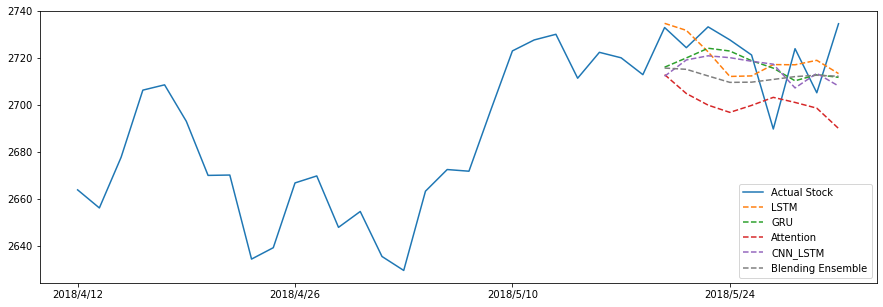

In [ ]:
# Charts
fig = plt.figure(figsize = (15, 5))

starting_time_idx = 85
models = ["LSTM", "GRU", "Attention", "CNN_LSTM", "Blending Ensemble"]
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:grey']
results = [m1_x_test, m2_x_test, m3_x_test, m4_x_test, predicted_stock_price]
# Actual Stock
plt.plot(df2.index[starting_time_idx:], df2['Adj Close'][starting_time_idx:], label = 'Actual Stock', c = 'tab:blue')
# Prediction
for i, r in enumerate(results):
    plt.plot(test_data.index[-9:], r, linestyle='dashed', label = '%s' % (models[i]), c = colors[i])

plt.xticks(df2.index[starting_time_idx::10], df2.index[starting_time_idx::10])
plt.legend()
plt.show()